# A Study on NYC's Taxi Journeys

### Import required libraries for analysis

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import to_timestamp, hour, when, avg, count

from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Initialize Spark Session

In [2]:
spark = SparkSession.builder.master('local[*]').getOrCreate()
sc = spark.sparkContext
spark

## Objective

The objective of this project is to conduct an in-depth analysis of **New York City yellow taxi trip data** across three targeted studies, focusing on **trip density, disputed trips, and financial performance**. Each study is designed to uncover critical insights into location-based and time-dependent patterns within the taxi service data, which can drive data-informed decisions for optimizing taxi operations.

This analysis employs three distinct implementations—**RDDs, DataFrames, and SQL queries**—to evaluate performance metrics including **execution time, data throughput, and processing speed**. By comparing these implementations, the aim is to highlight the most efficient methods for large-scale data analysis, delivering valuable insights to both drivers and service providers in maximizing operational and financial efficiency.

## Datasets

This project utilizes NYC Yellow Taxi datasets made publicly available by the NYC Taxi and Limousine Commission (TLC) through authorized technology providers under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP). The data can be accessed via the NYC TLC website at [TLC Trip Record Data](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

The two primary datasets used are as follows:
1. **January 2024 Yellow Taxi Trip Dataset**:
- This dataset includes detailed records of yellow taxi trips in NYC for January 2024.
- Key columns include:
    - **Pickup and Drop-off Dates/Times**: Timestamps of trip start and end, enabling time-based analysis.
    - **Passenger Count**: Number of passengers per trip.
    - **Trip Distance**: Distance traveled for each trip.
    - **Pickup and Drop-off Locations**: Specified by TLC-designated Taxi Zones.
    - **Rate Code**: Indicates the rate applied to the trip (e.g., standard, airport, group rates).
    - **Fare Amounts and Additional Fees**: Includes total fare, tips, tolls, surcharges, and applicable taxes.
    - **Payment Method**: Type of payment used, which can help analyze payment trends and preferences.

2. **Taxi Zone Lookup Dataset**:
- This dataset provides zone and location information for NYC’s designated taxi zones.
Contains mappings of Location IDs to boroughs and zones, enabling geographical and location-based analysis.

These datasets offer a comprehensive foundation for analyzing taxi operations, allowing for an examination of temporal, financial, and locational patterns critical to optimizing taxi services across NYC.


---
# Study 1: Trip Density by Location

## 1. Dataframe Implementation

This section highlights an initial analysis using a PySpark DataFrame to examine trip density by location in New York City. The objective is to analyze the volume of taxi trips by identifying the most frequent **pickup and drop-off locations**.

This study is designed to provide insights into high-demand areas and popular routes by calculating the frequency of trips between each pickup and drop-off pair. In the final output, we display the **top 20 trip routes** by frequency, offering a clear view of the busiest travel patterns in the city.

###  Read Datasets & Join Tables

In this step, we record the execution time while joining two key datasets: the `taxi_zone_lookup` dataset and the `NYC Yellow Taxi Trip Records` dataset. This join operation allows us to include descriptive names of the pickup and drop-off locations, enabling more meaningful analysis.

After completing the join, we perform **column renaming** to clearly distinguish between pickup and drop-off locations, preparing the data for subsequent analysis steps.

In [3]:
# Start time of execution
study1_df_start_time = time()
df = spark.read.format("parquet").load("yellow_tripdata_2024-01.parquet")

# Reading Taxi Zone Lookup CSV in order to join both tables later
locations_df1 = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True).select('LocationID','Borough')
locations_df2 = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True).select('LocationID','Borough')
t = df.join(locations_df1, locations_df1['LocationID'] == df['PULocationID']).withColumnRenamed('Borough','PULocation')
taxi_data = t.join(locations_df2, locations_df2['LocationID'] == t['DOLocationID']).withColumnRenamed('Borough','DOLocation')
taxi_data.select('PULocation','DOLocation').groupBy('PULocation','DOLocation').count().orderBy('count', ascending = False).show()

# Print the total execution time
study1_df_execution_time = round(time()-study1_df_start_time, 3)
print(study1_df_execution_time, "seconds elapsed for DataFrame implementation for Trip Density")

+----------+----------+-------+
|PULocation|DOLocation|  count|
+----------+----------+-------+
| Manhattan| Manhattan|2492571|
|    Queens| Manhattan| 150203|
| Manhattan|    Queens|  76535|
|    Queens|    Queens|  66343|
| Manhattan|  Brooklyn|  52145|
|    Queens|  Brooklyn|  41086|
|  Brooklyn|  Brooklyn|  13126|
| Manhattan|     Bronx|   8262|
|  Brooklyn| Manhattan|   8219|
| Manhattan|   Unknown|   7885|
|    Queens|       N/A|   7849|
|   Unknown|   Unknown|   7381|
| Manhattan|       EWR|   6462|
|    Queens|     Bronx|   6237|
|  Brooklyn|    Queens|   3124|
|     Bronx| Manhattan|   3032|
| Manhattan|       N/A|   2848|
|     Bronx|     Bronx|   2596|
|   Unknown| Manhattan|   2589|
|       N/A|       N/A|   1144|
+----------+----------+-------+
only showing top 20 rows

7.719 seconds elapsed for DataFrame implementation for Trip Density


In [4]:
# Calculate the total number of rows processed and the speed and display them
total_rows = taxi_data.count()
processing_speed = total_rows / study1_df_execution_time if study1_df_execution_time > 0 else 0
print(f"Total number of rows processed for Study1 DataFrame: {total_rows}")
print(f"Processing speed for Study 1 DataFrame: {processing_speed:.3f} row/s")

Total number of rows processed for Study1 DataFrame: 2964624
Processing speed for Study 1 DataFrame: 384068.403 row/s


## 2. RDD Implementation

In this section, we implement trip density analysis using PySpark RDDs. The approach involves converting our DataFrame to an RDD to explore low-level data manipulation techniques.
- First, map each trip record into a **key-value pair**, where the key is a tuple representing the pickup and drop-off locations (`PULocation`, `DOLocation`), and the **value** is 1.
- This mapping allows the frequency of each pickup-drop-off pair to be efficiently counted in later steps.

In [5]:
rdd = taxi_data.rdd

In [6]:
# Map each data as a key value pairs; key being the location tuples
locations = rdd.map(lambda x: ((x["PULocation"], x["DOLocation"]), 1))

### Calculate Execution Time with Aggregate & Sort Data
In this section, the **execution time** is measured for processing the RDD-based trip density analysis.

- A **reduction operation** is done to aggregate the total number of trips for each pickup-drop-off pair, counting the occurrences of each location pair.
- After aggregating, **results are sorted** in descending order to highlight the most frequent trips.
- Finally, the **top 20 trip routes** are displayed, providing insights into the highest-demand routes.

In [7]:
# Starting the time for this part
rdd_start_time = time()
trip_counts = locations.reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], False).take(20)
rdd_exec_time = round(time()-rdd_start_time, 3)

# print the total execution time
print(rdd_exec_time, "seconds elapsed for RDD implementation for Trip Density")

# Calculate total data processed in terms of rows
total_rows_rdd = rdd.count()

# Calculate processing speed
processing_speed_rdd = total_rows_rdd / rdd_exec_time  # in row per second

print(f"Processing speed for RDD implementation: {processing_speed_rdd:.3f} row/s")
print("Total number of rows processed for RDD:" ,total_rows_rdd)

28.432 seconds elapsed for RDD implementation for Trip Density
Processing speed for RDD implementation: 104270.681 row/s
Total number of rows processed for RDD: 2964624


### Display the results

In this section, the top 20 most frequent trip routes in New York City are presenetd, based on pickup and drop-off location pairs. These results show the locations with the highest trip density, providing a clear view of popular travel patterns across NYC.

In [8]:
trip_counts

[(('Manhattan', 'Manhattan'), 2492571),
 (('Queens', 'Manhattan'), 150203),
 (('Manhattan', 'Queens'), 76535),
 (('Queens', 'Queens'), 66343),
 (('Manhattan', 'Brooklyn'), 52145),
 (('Queens', 'Brooklyn'), 41086),
 (('Brooklyn', 'Brooklyn'), 13126),
 (('Manhattan', 'Bronx'), 8262),
 (('Brooklyn', 'Manhattan'), 8219),
 (('Manhattan', 'Unknown'), 7885),
 (('Queens', 'N/A'), 7849),
 (('Unknown', 'Unknown'), 7381),
 (('Manhattan', 'EWR'), 6462),
 (('Queens', 'Bronx'), 6237),
 (('Brooklyn', 'Queens'), 3124),
 (('Bronx', 'Manhattan'), 3032),
 (('Manhattan', 'N/A'), 2848),
 (('Bronx', 'Bronx'), 2596),
 (('Unknown', 'Manhattan'), 2589),
 (('N/A', 'N/A'), 1144)]

This output provides valuable insights into the most common taxi routes, helping identify high-demand areas and potential opportunities for optimizing taxi operations.

## 3. SQL implementation

In this section, the trip density analysis is implemented using Spark SQL for improved readability and conciseness. Below is the SQL query used to calculate the frequency of trips by pickup and drop-off locations:

```
WITH pu AS (
SELECT Borough AS PULocation, LocationID AS PULocationID FROM locinf
), 

do AS (
SELECT Borough AS DOLocation, LocationID AS DOLocationID FROM locinf
),

aux AS (
SELECT PULocation, DOLocation  FROM do JOIN (SELECT PULocation, DOLocationID FROM taxinf JOIN pu USING (PULocationID)) USING (DOLocationID)
) 

SELECT PULocation, DOLocation, COUNT("d") AS n_trips FROM aux GROUP BY PULocation, DOLocation ORDER BY n_trips DESC
```

Explanation:
- **Common Table Expressions (CTEs)**: use CTEs (`pu`, `do`, and `aux`) to simplify joins between tables:
    - `pu` and `do` extract pickup and drop-off location names and IDs from `locinf`.
    - `aux` joins these tables with `taxinf` to retrieve both pickup and drop-off locations.
- **Main Query**: The final query groups the data by `PULocation` and `DOLocation`, counting trips for each unique location pair and sorting the results in descending order based on trip count.

In [9]:
t0_sql = time() # Initialize timer for SQL implementation
df.createOrReplaceTempView('taxinf') # Create an alias for the main dataframe
locations_df1.createOrReplaceTempView('locinf') # Create an alias for the locationsID and their boroughs

# Query execution:
result = spark.sql('WITH pu AS (SELECT Borough AS PULocation, LocationID AS PULocationID FROM locinf), do AS (SELECT Borough AS DOLocation, LocationID AS DOLocationID FROM locinf), aux AS (SELECT PULocation, DOLocation  FROM do JOIN (SELECT PULocation, DOLocationID FROM taxinf JOIN pu USING (PULocationID)) USING (DOLocationID)) SELECT PULocation, DOLocation, COUNT("d") AS n_trips FROM aux GROUP BY PULocation, DOLocation ORDER BY n_trips DESC')
result.show() # Show 20 first results of the query.
tf_sql = time() # Stop the timer for SQL implementation.


sql_exec_time = tf_sql - t0_sql # Compute the elapsed time for SQL implementation.
total_rows_sql = df.count() # Compute the total amount of data processed.
processing_speed_sql = total_rows_sql / sql_exec_time # Compute the processing speed.


print(np.round(tf_sql - t0_sql, 3), 'seconds elapsed for SQL implementation.') # Print the elapsed time
print('Total number of rows processed for SQL:', total_rows_sql) # Print the total amount of rows
print(f"Processing speed for SQL implementation: {processing_speed_sql:.3f} row/s") # Print the processing speed

+----------+----------+-------+
|PULocation|DOLocation|n_trips|
+----------+----------+-------+
| Manhattan| Manhattan|2492571|
|    Queens| Manhattan| 150203|
| Manhattan|    Queens|  76535|
|    Queens|    Queens|  66343|
| Manhattan|  Brooklyn|  52145|
|    Queens|  Brooklyn|  41086|
|  Brooklyn|  Brooklyn|  13126|
| Manhattan|     Bronx|   8262|
|  Brooklyn| Manhattan|   8219|
| Manhattan|   Unknown|   7885|
|    Queens|       N/A|   7849|
|   Unknown|   Unknown|   7381|
| Manhattan|       EWR|   6462|
|    Queens|     Bronx|   6237|
|  Brooklyn|    Queens|   3124|
|     Bronx| Manhattan|   3032|
| Manhattan|       N/A|   2848|
|     Bronx|     Bronx|   2596|
|   Unknown| Manhattan|   2589|
|       N/A|       N/A|   1144|
+----------+----------+-------+
only showing top 20 rows

2.094 seconds elapsed for SQL implementation.
Total number of rows processed for SQL: 2964624
Processing speed for SQL implementation: 1415768.932 row/s


## Visualization

In this section, the results from the DataFrame implementation are used to visualize the **top 5 most frequent routes**. These high-density routes are of particular interest, as they represent key travel patterns in New York City. Highlighting these routes provides valuable insights for drivers, allowing them to identify popular pickup and drop-off locations that may maximize fare opportunities.

The visualization focuses on these top routes to illustrate the demand distribution and support decision-making for optimized routing.

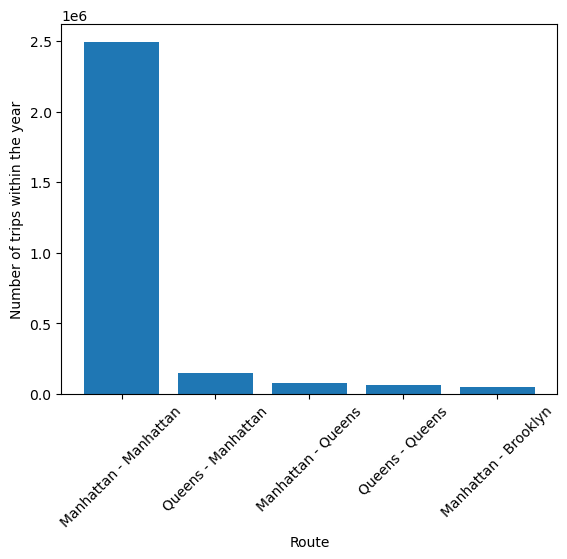

In [10]:
data = taxi_data.select('PULocation','DOLocation').groupBy('PULocation','DOLocation').count().orderBy('count', ascending = False).head(5)
x = [f"{row[0]} - {row[1]}" for row in data]
y = [row[2] for row in data]
plt.figure()
plt.bar(x, y)
plt.xlabel('Route')
plt.ylabel('Number of trips within the year')
plt.xticks(rotation=45)  
plt.show()

The visualization shows that in 2024, the majority of NYC yellow taxi trips occurred **within the Manhattan borough**—significantly outpacing other routes by more than an order of magnitude. This result aligns with Manhattan's status as a major business and tourist hub, leading to consistently higher taxi demand within its boundaries. Other popular routes, such as trips between Manhattan and Queens, appear with much lower frequencies, indicating that Manhattan remains the primary location for taxi services throughout the year.

---
# Study 2 - Trips not Paid by Pick-up Location

This study focuses on analyzing **disputed taxi trips** across New York City, specifically examining how **pickup location** `(PUZone)` influences the likelihood of fare disputes. By identifying areas with a higher frequency of disputed fares, the aim is to uncover patterns that may suggest common causes—such as fare misunderstandings, distance-related issues, or location-specific factors. This analysis can help stakeholders address fare disputes more effectively and improve service reliability in high-dispute zones.

In [11]:
# Select only the relevant columns: 'LocationID' and 'Zone', which will be used to associate trip data with specific zones.
zone_df1 = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True).select('LocationID','Zone')

In [12]:
# Perform an inner join between the 'taxi_data' DataFrame and 'zone_df1' DataFrame using 'LocationID' 
# from 'zone_df1' and 'PULocationID' from 'taxi_data' as the join keys.
study2_df1 = taxi_data.join(zone_df1, zone_df1['LocationID'] == taxi_data['PULocationID']).withColumnRenamed('Zone','PUZone')

In [13]:
# Filter the 'study2_df1' DataFrame to include only records where the 'payment_type' column 
# indicates disputed or unpaid trips. 
study2_df2 = study2_df1.filter(taxi_data.payment_type.isin('3','4','5','6'))

In [14]:
# Group the filtered DataFrame by 'PUZone', count the number of disputed trips per zone, 
# and display the results in descending order of trip count.
study2_df3 = study2_df2.select('PUZone').groupBy('PUZone').count().orderBy('count', ascending = False).show()

+--------------------+-----+
|              PUZone|count|
+--------------------+-----+
|         JFK Airport| 7077|
|Times Sq/Theatre ...| 3046|
|      Midtown Center| 2908|
|Upper East Side S...| 2523|
|Penn Station/Madi...| 2392|
|        Midtown East| 2220|
|        Clinton East| 2102|
|Upper East Side N...| 1949|
| Lincoln Square East| 1830|
|       Midtown North| 1813|
|   LaGuardia Airport| 1781|
|         Murray Hill| 1636|
|        East Chelsea| 1602|
|       Midtown South| 1491|
|    Garment District| 1474|
|     Lenox Hill West| 1432|
|Upper West Side S...| 1348|
|        East Village| 1346|
|            Union Sq| 1256|
|        West Village| 1201|
+--------------------+-----+
only showing top 20 rows



In [15]:
from pyspark.sql import functions as F

# Filter for trips with disputed or unpaid fares and count the occurrences of each pickup zone (PUZone).
non_payment_df = study2_df1.filter(study2_df1.payment_type.isin('3', '4', '5', '6'))
non_payment_count_df = non_payment_df.groupBy('PUZone').agg(F.count('PUZone').alias('non_payment_count'))

In [16]:
# Group the DataFrame by 'PUZone' and count the total number of trips for each pickup zone.
total_count_df = study2_df1.groupBy('PUZone').agg(F.count('PUZone').alias('total_count'))

In [17]:
# Join 'non_payment_count_df' with 'total_count_df' on 'PUZone' to include both counts.
# Calculate the non-payment probability by dividing 'non_payment_count' by 'total_count' 
# and add it as a new column 'non_payment_probability'.
probability_df = non_payment_count_df.join(total_count_df, 'PUZone') \
    .withColumn('non_payment_probability', F.col('non_payment_count') / F.col('total_count'))

In [18]:
# Sort the DataFrame by 'non_payment_probability' in descending order and display the results.
probability_df.orderBy('non_payment_probability', ascending=False).show()

+--------------------+-----------------+-----------+-----------------------+
|              PUZone|non_payment_count|total_count|non_payment_probability|
+--------------------+-----------------+-----------+-----------------------+
|       West Brighton|                2|          2|                    1.0|
|     Mariners Harbor|                3|          4|                   0.75|
|Bloomfield/Emerso...|                2|          4|                    0.5|
|Queensbridge/Rave...|              978|       2184|     0.4478021978021978|
|       Willets Point|                6|         14|    0.42857142857142855|
|         Westerleigh|                2|          5|                    0.4|
|        Country Club|                2|          6|     0.3333333333333333|
|           Stapleton|                1|          4|                   0.25|
|Forest Park/Highl...|                2|         12|    0.16666666666666666|
|Marine Park/Floyd...|                9|         58|    0.15517241379310345|

In [19]:
# Checking probability df: displays the zones with the highest number of non-payment incidents at the top
probability_df.select('PUZone','non_payment_count').orderBy('non_payment_count', ascending = False).show()

+--------------------+-----------------+
|              PUZone|non_payment_count|
+--------------------+-----------------+
|         JFK Airport|             7077|
|Times Sq/Theatre ...|             3046|
|      Midtown Center|             2908|
|Upper East Side S...|             2523|
|Penn Station/Madi...|             2392|
|        Midtown East|             2220|
|        Clinton East|             2102|
|Upper East Side N...|             1949|
| Lincoln Square East|             1830|
|       Midtown North|             1813|
|   LaGuardia Airport|             1781|
|         Murray Hill|             1636|
|        East Chelsea|             1602|
|       Midtown South|             1491|
|    Garment District|             1474|
|     Lenox Hill West|             1432|
|Upper West Side S...|             1348|
|        East Village|             1346|
|            Union Sq|             1256|
|        West Village|             1201|
+--------------------+-----------------+
only showing top

In [20]:
# Final df: zones with the highest probability of non-payment at the top, focusing on pickup locations.
study2_df_final = probability_df.select('PUZone','non_payment_probability').orderBy('non_payment_probability', ascending = False).show()

+--------------------+-----------------------+
|              PUZone|non_payment_probability|
+--------------------+-----------------------+
|       West Brighton|                    1.0|
|     Mariners Harbor|                   0.75|
|Bloomfield/Emerso...|                    0.5|
|Queensbridge/Rave...|     0.4478021978021978|
|       Willets Point|    0.42857142857142855|
|         Westerleigh|                    0.4|
|        Country Club|     0.3333333333333333|
|           Stapleton|                   0.25|
|Forest Park/Highl...|    0.16666666666666666|
|Marine Park/Floyd...|    0.15517241379310345|
|           Bellerose|    0.14634146341463414|
|Briarwood/Jamaica...|    0.13470319634703196|
|     Jackson Heights|    0.12157721796276014|
|Flushing Meadows-...|    0.11764705882352941|
|      Outside of NYC|    0.11459589867310012|
|            Woodside|     0.0996309963099631|
|       Prospect Park|    0.09433962264150944|
|       Fresh Meadows|    0.09210526315789473|
|            

1. **Zones with High Non-Payment Probability**:

- **West Brighton** has a 100% non-payment rate, but with a very low volume (2 out of 2 trips), suggesting high risk but low occurrence.
- **Mariners Harbor** and **Bloomfield/Emerson Hill** also show high probabilities (75% and 50%, respectively), though with limited data points.

2. **High Volume Zones with Moderate Non-Payment Probability**:

- **Queensbridge/Ravenswood** and **Jackson Heights** have relatively high non-payment counts (978 and 111 disputed trips) with probabilities around 45% and 12%, indicating both high risk and frequent occurrences in these areas.
- **Astoria** and **Outside of NYC** locations have significant counts (155 and 190 disputes) with non-payment probabilities around 8-11%, suggesting they may be more consistent sources of disputes, albeit at a lower risk level than the highest zones.

3. **Potential Influence of Zone Type**:

- Many high-probability zones are likely residential or lower-traffic areas, while zones like **Jackson Heights** and **Astoria** represent busier neighborhoods with a high volume of trips.

These results highlight specific zones with a higher likelihood of fare disputes, offering insights into potential areas for focused service improvement or driver awareness.

### Data Visualization

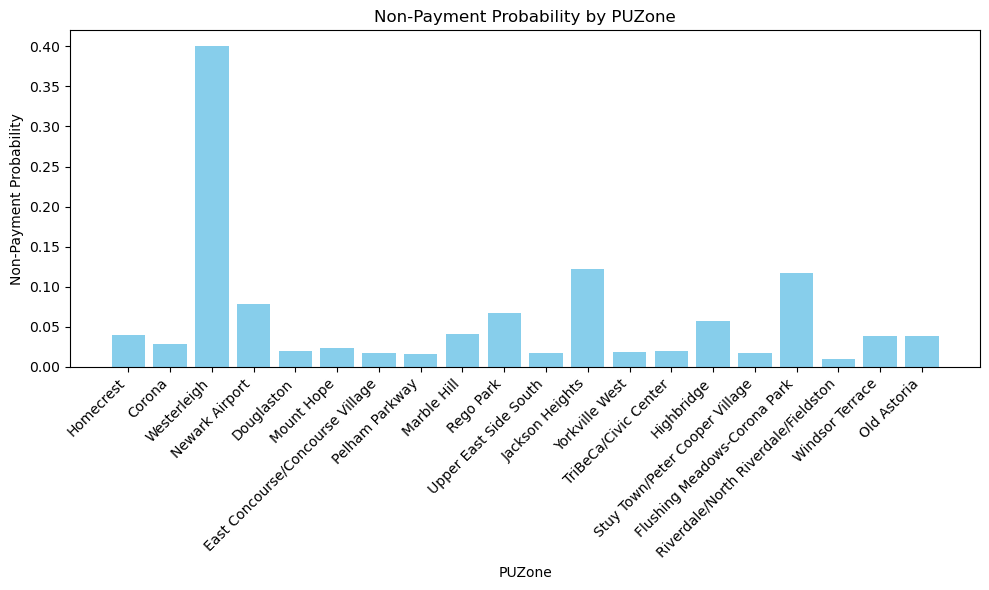

In [21]:
pd_probability_df = probability_df.select('PUZone', 'non_payment_probability').limit(20).toPandas()

plt.figure(figsize=(10, 6))
plt.bar(pd_probability_df['PUZone'], pd_probability_df['non_payment_probability'], color='skyblue')
plt.title('Non-Payment Probability by PUZone')
plt.xlabel('PUZone')
plt.ylabel('Non-Payment Probability')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Execution

In [22]:
start_time = time()

non_payment_df = study2_df1.filter(study2_df1.payment_type.isin('3', '4', '5', '6'))
non_payment_count_df = non_payment_df.groupBy('PUZone').agg(F.count('PUZone').alias('non_payment_count'))
total_count_df = study2_df1.groupBy('PUZone').agg(F.count('PUZone').alias('total_count'))
probability_df = non_payment_count_df.join(total_count_df, 'PUZone') \
    .withColumn('non_payment_probability', F.col('non_payment_count') / F.col('total_count'))

end_time = time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

data_processed = probability_df.count()
print(f"Amount of data processed: {data_processed} rows")

processing_speed = data_processed / execution_time
print(f"Processing speed: {processing_speed} rows/second")


Execution time: 0.10558152198791504 seconds
Amount of data processed: 217 rows
Processing speed: 2055.2838784123423 rows/second


---
# Study 3 - Financial Performance Analysis

The objective of Study 3 is to analyze the average total fare (including tips) per trip based on different times of the day: morning, afternoon, evening, and night. By categorizing trips according to pickup times, the aim is to uncover temporal fare patterns that could indicate peak times and revenue variations throughout the day. This analysis can be helpful for identifying high-revenue time periods, which may influence operational decisions.

Spark DataFrames were used to achieve these goals, as they offer optimized distributed data processing suitable for handling large datasets while also providing high-level functions, making complex aggregations and transformations efficient and intuitive.

In [23]:
# 1. Start timer
study3_start_time = time()

# 2. Extract hour and define time of day categories
# Convert 'tpep_pickup_datetime' to timestamp if necessary (format: "DD/MM/YYYY HH:MM:SS")
df = df.withColumn("tpep_pickup_datetime", to_timestamp("tpep_pickup_datetime", "dd/MM/yyyy HH:mm:ss"))

# Extract hour and categorize time of day
df = df.withColumn("hour", hour("tpep_pickup_datetime"))
df = df.withColumn(
    "time_of_day",
    when((df["hour"] >= 6) & (df["hour"] < 12), "morning")
    .when((df["hour"] >= 12) & (df["hour"] < 18), "afternoon")
    .when((df["hour"] >= 18) & (df["hour"] < 22), "evening")
    .otherwise("night")
)

# 3. Calculate average fare per trip by time of day
result_study3 = df.groupBy("time_of_day").agg(avg("total_amount").alias("avg_total_fare"))

# 4. Sort results by time of day and display
result_study3 = result_study3.orderBy("time_of_day")
result_study3.show()

# 5. Performance metrics
study3_execution_time = round(time() - study3_start_time, 3)  # Calculate execution time
total_rows_study3 = df.count()  # Total rows processed
processing_speed_study3 = total_rows_study3 / study3_execution_time if study3_execution_time > 0 else 0  # Rows per second

print(f"- Execution time for Study 3: {study3_execution_time} seconds")
print(f"- Total rows processed for Study 3: {total_rows_study3}")
print(f"- Processing speed for Study 3: {processing_speed_study3:.3f} rows/second")

+-----------+------------------+
|time_of_day|    avg_total_fare|
+-----------+------------------+
|  afternoon|27.080402002580364|
|    evening|26.724274450081243|
|    morning|25.707210734324185|
|      night|27.775825010400784|
+-----------+------------------+

- Execution time for Study 3: 0.814 seconds
- Total rows processed for Study 3: 2964624
- Processing speed for Study 3: 3642044.226 rows/second


### Data Visualization

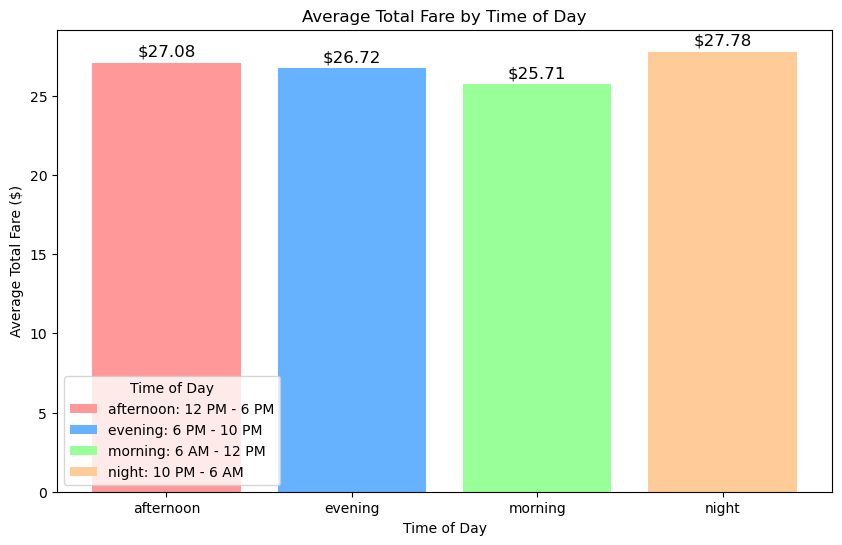

In [24]:
# For better data visualization

# Convert the Spark DataFrame result to Pandas
result_pandas = result_study3.toPandas()

# Ensure DataFrame is sorted by time of day
result_pandas = result_pandas.sort_values(by="time_of_day")

# Define unique colors for each time of day
colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99"]

# Time period descriptions for each part of the day
time_periods = {
    "morning": "6 AM - 12 PM",
    "afternoon": "12 PM - 6 PM",
    "evening": "6 PM - 10 PM",
    "night": "10 PM - 6 AM"
}

# Plotting the average fare by time of day with unique colors
plt.figure(figsize=(10, 6))
bars = plt.bar(result_pandas["time_of_day"], result_pandas["avg_total_fare"], color=colors)

# Add average values on top of each bar
for bar, avg_fare in zip(bars, result_pandas["avg_total_fare"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.25, f'${avg_fare:.2f}', 
             ha='center', va='bottom', color="black", fontsize=12)

# Add legend with time periods for each time of day
legend_labels = [f"{period}: {time_periods[period]}" for period in result_pandas["time_of_day"]]
plt.legend(bars, legend_labels, title="Time of Day")

# Titles and labels
plt.title("Average Total Fare by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Average Total Fare ($)")
plt.show()

### Data Insights:

- **Night** shows the highest average fare per trip at **27.78 USD**, suggesting potentially higher demand or increased fare rates during nighttime.
- **Afternoon** follows closely at **27.08 USD**, possibly indicating another peak period in the day, likely driven by rush hour or increased travel activity.
- **Morning** has the lowest average fare of **25.71 USD**, which might indicate a lower demand or shorter trip distances during early hours.
- **Evening** fares are relatively stable at **26.72 USD**, showing moderate revenue per trip compared to other times.

These results offer insight into fare variability across different times of the day, potentially reflecting travel demand patterns and fare adjustments in January. This can be useful for scheduling, pricing, and operational planning to maximize revenue during peak hours.


# Results

In [37]:
# Performance Analysis

# Define the data from the notebook results, with each entry representing cores 1 through 8
task_1_rdd = np.array([58.339, 43.515, 27.678, 28.119, 27.517, 28.007, 29.187, 28.432])
task_1_df = np.array([8.952, 8.105, 7.981, 7.771, 7.942, 7.941, 8.045, 7.719])
task_1_sql = np.array([2.487, 1.918, 1.801, 1.752, 1.983, 1.955, 2.198, 2.094])
task_2_df = np.array([0.1018972396850586, 0.0996553897857666, 0.09444308280944824, 0.09234713554382324,
                      0.09304359817504883, 0.09740804023742676, 0.0996236381530762, 0.10558152198791504])
task_3_df = np.array([0.986, 0.854, 0.795, 0.74, 0.744, 0.746, 0.764, 0.814])

# Combine them into a DataFrame for easier analysis
df_exec_times = pd.DataFrame({
    "Cores": np.arange(1, 9),
    "Task 1 - RDDs": task_1_rdd,
    "Task 1 - DataFrame": task_1_df,
    "Task 1 - SQL": task_1_sql,
    "Task 2 - DataFrame": task_2_df,
    "Task 3 - DataFrame": task_3_df
})

# Display the DataFrame for user inspection
df_exec_times

,Cores,Task 1 - RDDs,Task 1 - DataFrame,Task 1 - SQL,Task 2 - DataFrame,Task 3 - DataFrame
0,1,58.339,8.952,2.487,0.101897,0.986
1,2,43.515,8.105,1.918,0.099655,0.854
2,3,27.678,7.981,1.801,0.094443,0.795
3,4,28.119,7.771,1.752,0.092347,0.740
4,5,27.517,7.942,1.983,0.093044,0.744
5,6,28.007,7.941,1.955,0.097408,0.746
6,7,29.187,8.045,2.198,0.099624,0.764
7,8,28.432,7.719,2.094,0.105582,0.814


### Performance Analysis Based on Number of Cores

The performance results reveal how execution times across tasks vary with the number of cores, highlighting the scalability and efficiency of different implementations (RDD, DataFrame, SQL) in Spark.

1. **Task 1 - RDDs**:
   - Execution times decrease significantly from 1 core (58.34 seconds) to 3 cores (27.68 seconds), indicating strong performance improvement as parallelism increases.
   - Beyond 3 cores, performance plateaus and even fluctuates, with little additional benefit from adding cores, likely due to overhead in RDD management and diminishing returns on parallelism.

2. **Task 1 - DataFrame**:
   - The DataFrame implementation consistently outperforms RDDs, starting at 8.95 seconds with 1 core and achieving its lowest time of 7.72 seconds with 8 cores.
   - Though the speed-up with more cores is marginal beyond 2 cores, the overall efficiency indicates that DataFrames handle parallel processing more effectively than RDDs.

3. **Task 1 - SQL**:
   - SQL execution times start at 2.49 seconds with 1 core and stabilize around 1.75-1.95 seconds from 3 to 8 cores.
   - This implementation shows the least benefit from additional cores, possibly due to Spark SQL's internal optimizations and efficient query planning, which require less parallelism for improvements.

4. **Task 2 and Task 3 - DataFrame**:
   - Both tasks are relatively lightweight, showing only minor improvements with additional cores. For example, Task 2 decreases slightly from 0.10 seconds to around 0.09 seconds, while Task 3 hovers near 0.74-0.81 seconds across all cores.
   - The minor changes suggest that these tasks are less CPU-intensive, so increasing core count has limited impact.

### Summary
- **RDDs** benefit most from parallelism initially but face diminishing returns after 3 cores.
- **DataFrames** offer more stable and efficient performance, making them suitable for larger tasks across varying core counts.
- **SQL** is minimally affected by core count due to its built-in optimizations, showing stable performance with fewer cores.

These results suggest that for large-scale, high-complexity tasks, **DataFrames and SQL** are preferred over RDDs for both speed and efficiency.

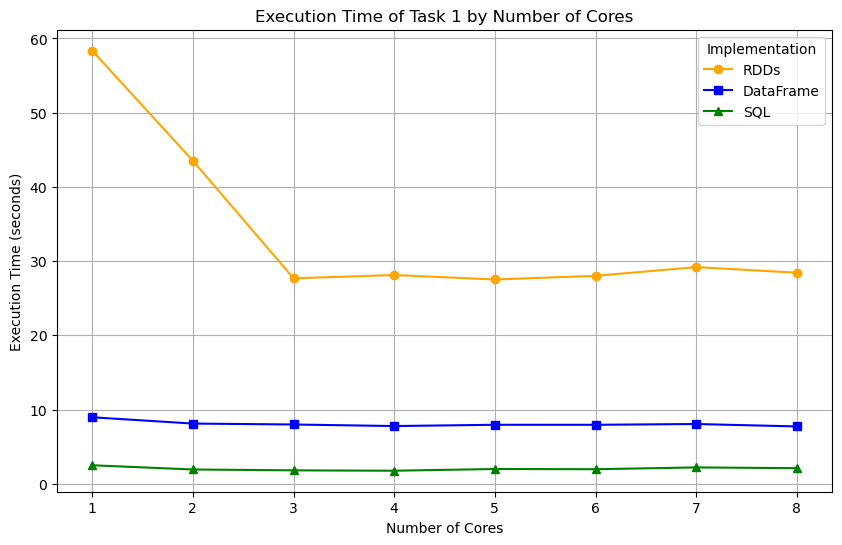

In [38]:
# Plotting execution time for Task 1
plt.figure(figsize=(10, 6))

# Plot each implementation with a unique color and marker
cores = np.arange(1,9)
plt.plot(cores, task_1_rdd, label="RDDs", marker='o', color='orange')
plt.plot(cores, task_1_df, label="DataFrame", marker='s', color='blue')
plt.plot(cores, task_1_sql, label="SQL", marker='^', color='green')

# Adding labels and title
plt.xlabel("Number of Cores")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time of Task 1 by Number of Cores")
plt.legend(title="Implementation")
plt.grid(True)

# Show plot
plt.show()

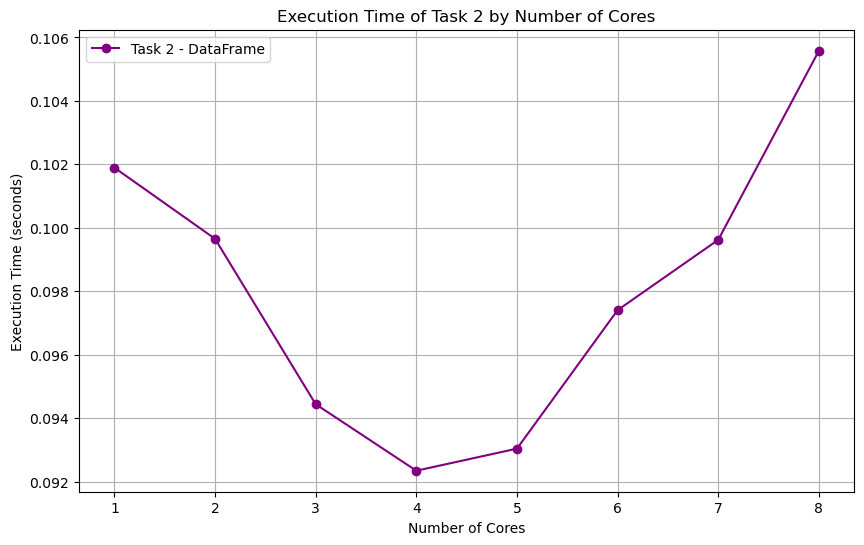

In [39]:
# Define core counts and execution times for Task 2
cores = df_exec_times["Cores"]
task_2_times = df_exec_times["Task 2 - DataFrame"]

# Plot Task 2 execution times
plt.figure(figsize=(10, 6))
plt.plot(cores, task_2_times, marker='o', color='purple', label="Task 2 - DataFrame")

# Adding labels and title
plt.xlabel("Number of Cores")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time of Task 2 by Number of Cores")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

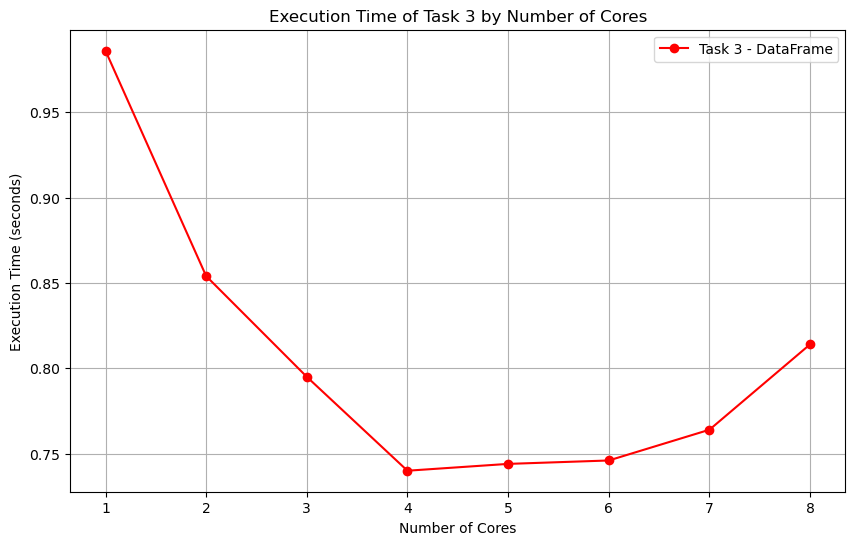

In [40]:
# Define core counts and execution times for Task 3
task_3_times = df_exec_times["Task 3 - DataFrame"]

# Plot Task 3 execution times
plt.figure(figsize=(10, 6))
plt.plot(cores, task_3_times, marker='o', color='red', label="Task 3 - DataFrame")

# Adding labels and title
plt.xlabel("Number of Cores")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time of Task 3 by Number of Cores")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

### Possible Speed-up

In [41]:
# Calculate the speed-up
df_speed_up = pd.DataFrame(index=range(len(df_exec_times)))

for col_name in df_exec_times.columns:
    if col_name == 'Cores':
        # Keep the 'Cores' column as is
        df_speed_up[col_name] = df_exec_times[col_name]
    else:
        # Calculate the speed-up as time with 1 core / time with current cores
        base_time = df_exec_times.loc[df_exec_times['Cores'] == 1, col_name].iloc[0]
        df_speed_up[col_name] = base_time / df_exec_times[col_name]

df_speed_up

,Cores,Task 1 - RDDs,Task 1 - DataFrame,Task 1 - SQL,Task 2 - DataFrame,Task 3 - DataFrame
0,1,1.000000,1.000000,1.000000,1.000000,1.000000
1,2,1.340664,1.104503,1.296663,1.022496,1.154567
2,3,2.107775,1.121664,1.380900,1.078928,1.240252
3,4,2.074718,1.151975,1.419521,1.103415,1.332432
4,5,2.120108,1.127172,1.254160,1.095156,1.325269
5,6,2.083015,1.127314,1.272123,1.046087,1.321716
6,7,1.998801,1.112741,1.131483,1.022822,1.290576
7,8,2.051878,1.159736,1.187679,0.965105,1.211302


### Speedup Analysis Based on Number of Cores

The **speedup** results show how each task scales as more cores are added, with speedup values indicating the factor of performance improvement relative to single-core execution. Higher values indicate better utilization of parallel processing.

1. **Task 1 - RDDs**:
   - RDDs show substantial speedup initially, reaching **2.11x** with 3 cores. However, this improvement stabilizes and slightly fluctuates beyond 3 cores, indicating limited parallelism gains due to overhead and diminishing returns.
   - The highest speedup observed is around **2.12x** with 5 cores, after which performance gains plateau, making additional cores less effective for RDD-based tasks.

2. **Task 1 - DataFrame**:
   - DataFrames display moderate, stable speedup across cores, beginning at **1.10x** with 2 cores and achieving a maximum speedup of **1.16x** with 8 cores.
   - The consistent yet modest improvements suggest that DataFrames benefit from multi-core processing but face diminishing returns beyond a few cores due to Spark’s internal optimizations, which already streamline DataFrame execution.

3. **Task 1 - SQL**:
   - SQL implementations initially achieve notable speedups, reaching **1.42x** with 4 cores, but exhibit only minor gains with additional cores, fluctuating between **1.13x** and **1.42x** from 5 to 8 cores.
   - This pattern reflects Spark SQL's efficient internal execution planning, which leverages multi-core processing effectively up to a certain point, beyond which additional cores offer limited benefits.

4. **Task 2 and Task 3 - DataFrame**:
   - These lightweight DataFrame tasks show minimal speedup, with values generally hovering between **1.02x and 1.33x** as cores increase.
   - The modest improvements indicate that these tasks are not CPU-bound, and additional cores contribute minimally to performance. Task 2, in particular, shows a slight decline in speedup beyond 4 cores, reflecting that it benefits less from parallel processing.

### Summary
- **RDDs** demonstrate the largest initial speedup, benefiting significantly from parallelism up to 3-5 cores, but plateauing beyond that point.
- **DataFrames** and **SQL** show stable, moderate speedups, with SQL achieving efficient speedup early and DataFrames benefiting up to around 8 cores.
- **Lightweight tasks** (Task 2 and Task 3) are not CPU-intensive, achieving only minor speedup due to low processing requirements.

Overall, RDDs leverage parallelism effectively at first but face scalability limits. **DataFrames and SQL** are better suited for stable performance across multiple cores, with SQL proving efficient even with fewer cores.

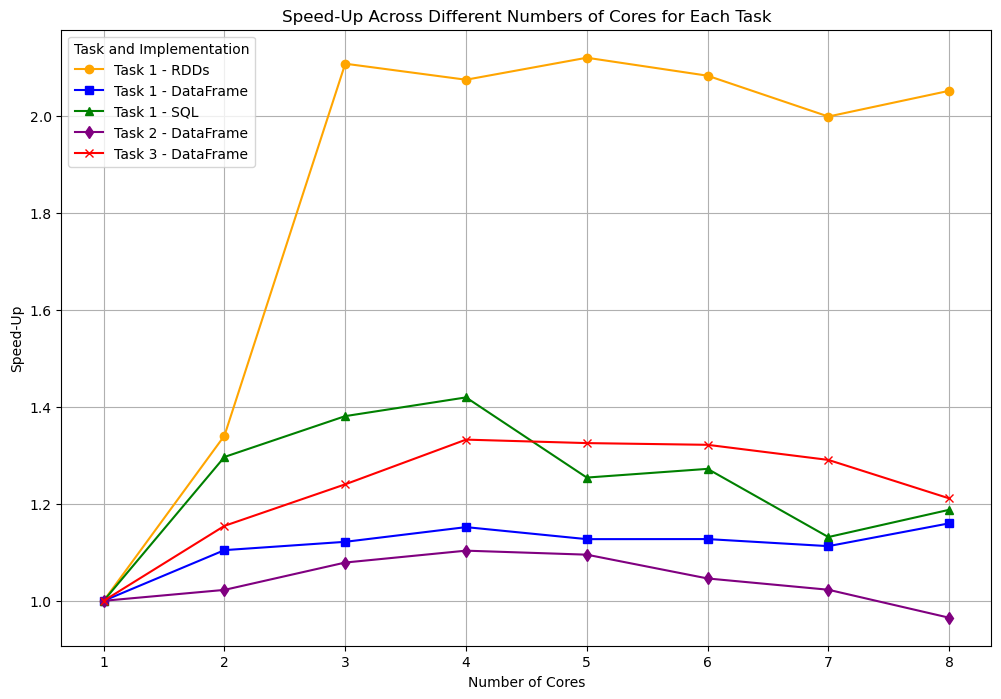

In [42]:
# Define core counts (x-axis)
cores = df_speed_up["Cores"]

# Plot speed-up values for each task
plt.figure(figsize=(12, 8))

# Task 1 speed-up plots
plt.plot(cores, df_speed_up["Task 1 - RDDs"], label="Task 1 - RDDs", marker='o', color='orange')
plt.plot(cores, df_speed_up["Task 1 - DataFrame"], label="Task 1 - DataFrame", marker='s', color='blue')
plt.plot(cores, df_speed_up["Task 1 - SQL"], label="Task 1 - SQL", marker='^', color='green')

# Task 2 and Task 3 speed-up plots
plt.plot(cores, df_speed_up["Task 2 - DataFrame"], label="Task 2 - DataFrame", marker='d', color='purple')
plt.plot(cores, df_speed_up["Task 3 - DataFrame"], label="Task 3 - DataFrame", marker='x', color='red')

# Labeling and title
plt.xlabel("Number of Cores")
plt.ylabel("Speed-Up")
plt.title("Speed-Up Across Different Numbers of Cores for Each Task")
plt.legend(title="Task and Implementation")
plt.grid(True)

# Show plot
plt.show()

---
# Conclusion

By examining performance across tasks and varying core counts, insights were uncovered into both data trends and the computational efficiency of each Spark structure.

Key findings include:

1. **Data Trends**:
   - **Trip Density**: Most trips occurred within Manhattan, reflecting high demand in tourist and business areas. This high density highlights areas where taxi operations could focus to maximize trip frequency.
   - **Fare Disputes**: Certain zones, especially residential or less central locations, showed a higher probability of disputed or unpaid fares. Identifying these zones allows for targeted improvements in fare transparency or service adjustments.
   - **Financial Patterns**: Average fare data, segmented by time of day, revealed peak times and revenue patterns, offering insights for drivers and service providers to optimize operations based on high-revenue periods.

2. **Performance and Speedup Analysis**:
   - **Optimal Core Usage**: Across all tasks, **3-4 cores** provided the most significant performance improvements, particularly for RDDs. Beyond this range, speedup gains diminished, highlighting an optimal core allocation for Spark jobs of this nature.
   - **RDDs for Computation-Heavy Tasks**: RDDs demonstrated the most substantial speedup with added cores, achieving up to **2.1x speedup** at 3-4 cores. This indicates RDDs are well-suited for computation-heavy, iterative tasks where high parallelism benefits processing times.
   - **DataFrames for Efficiency and Stability**: DataFrames performed efficiently and provided stable performance gains up to 4 cores. Their high-level API combined with optimized execution makes them ideal for tasks involving data manipulation and aggregation without high computational overhead.
   - **SQL for Simplicity with Minimal Overhead**: SQL queries showed minimal speedup, peaking at 1.16x, likely due to I/O limitations. SQL queries remain a powerful tool for readability and straightforward analysis but offer limited scalability compared to RDDs and DataFrames in highly parallel environments.

In summary, Spark’s DataFrames provide a balance between efficiency and ease of use for typical data analysis, while RDDs excel in tasks requiring extensive computation. SQL-based approaches, though less scalable, offer a user-friendly option for specific analytical tasks. By strategically selecting Spark structures based on task complexity and resource availability, performance can be optimized while effectively analyzing complex datasets, as demonstrated in this study.